In [39]:
import numpy as np

def solve_wage_sticky_flexprice_custom_i(
    i_seq,                     # exogenous nominal rate path (length T)
    u_seq=None,                # demand/preference shock path (length T), default 0
    beta=1/(1+0.01), sigma=1.0, phi=2.0, kappa_w=0.05,
    pi_T=0.0, pi_Tplus1=0.0    # terminal inflation values π_T, π_{T+1}
):
    """
    Deterministic NK with Rotemberg sticky wages, flexible prices, flat productivity.
    Solves for inflation π_t and consumption c_t given a user-supplied interest-rate path i_t.

    Equations:
      π_t = β π_{t+1} + K c_t
      c_t = c_{t+1} - (1/σ)( i_t - π_{t+1} - u_t )
    with K = κ_w (σ + φ). Goods-price inflation equals wage inflation here.

    Returns: dict with arrays of length T and residual checks.
    """
    i_seq = np.asarray(i_seq, dtype=float)
    T = len(i_seq)
    if T == 0:
        raise ValueError("i_seq must have positive length.")
    if u_seq is None:
        u_seq = np.zeros(T, dtype=float)
    else:
        u_seq = np.asarray(u_seq, dtype=float)
        if len(u_seq) != T:
            raise ValueError("u_seq must have the same length as i_seq.")

    K = kappa_w * (sigma + phi)

    # Inflation with two-step terminal conditions
    pi = np.zeros(T + 2)
    pi[T] = pi_T
    pi[T+1] = pi_Tplus1

    # Backward recursion: π_t = (1+β+K/σ)π_{t+1} - βπ_{t+2} - (K/σ)i_t + (K/σ)u_t
    A = 1.0 + beta + K / sigma
    B = beta
    C = K / sigma
    for t in range(T - 1, -1, -1):
        pi[t] = A * pi[t+1] - B * pi[t+2] - C * i_seq[t] + C * u_seq[t]

    # Recover c_t
    c = (pi[:T] - beta * pi[1:T+1]) / K

    # In this flex-price, flat-productivity case: π (goods) = π (wage), y_t = c_t, n_t = c_t
    results = {
        "pi": pi[:T],                # inflation
        "c": c,                      # consumption = output gap here
        "y": c,
        "n": c,
        "i": i_seq,
        "u": u_seq
    }

    # Residual checks
    is_resid = c - np.r_[c[1:], 0.0] + (1.0 / sigma) * (i_seq - pi[1:T+1] - u_seq)
    nkpc_resid = pi[:T] - beta * pi[1:T+1] - K * c
    results["is_resid"] = is_resid
    results["nkpc_resid"] = nkpc_resid
    results["max_abs_IS_resid"] = float(np.max(np.abs(is_resid)))
    results["max_abs_NKPC_resid"] = float(np.max(np.abs(nkpc_resid)))
    return results

# ---------- Example (delete/replace with your own sequences) ----------
if __name__ == "__main__":
    T = 60
    # Custom i_t: -100bp on impact, AR(0.6) back to 0
    i_custom = np.zeros(T); i_custom[0] = -0.01
    for t in range(1, T): i_custom[t] = 0.6 * i_custom[t-1]

    # Demand shock u_t (optional). Here: +50bp on impact, AR(0.7)
    u_custom = np.zeros(T); u_custom[0] = 0.005
    for t in range(1, T): u_custom[t] = 0.7 * u_custom[t-1]

    res = solve_wage_sticky_flexprice_custom_i(
        i_seq=i_custom, u_seq=u_custom,
        beta=0.99, sigma=1.0, phi=3.0, kappa_w=0.05,
        pi_T=0.0, pi_Tplus1=0.0
    )
    print("max|IS residual|:", res["max_abs_IS_resid"])
    print("max|wage-NKPC residual|:", res["max_abs_NKPC_resid"])
    # res["pi"], res["c"], res["y"], res["n"] are your IRFs. Plot however you like.


max|IS residual|: 1.4432899320127035e-15
max|wage-NKPC residual|: 5.551115123125783e-17


In [40]:
import numpy as np

def solve_wage_sticky_flexprice_with_productivity_fixed(
    T, beta=1/1.01, sigma=1.0, phi=2, kappa_w=0.05,
    u_seq=None, a_seq=None,
    closure="custom_i", i_seq=None,
    pi_T=0.0, pi_Tplus1=0.0, phi_pi=1.5
):
    """
    SS-anchored deterministic NK (Rotemberg sticky wages, flexible goods prices).
    This version now returns:
      - x (gap) = your original `c`
      - y_n_hat (natural output deviation from SS, from productivity)
      - y_hat = x + y_n_hat (actual output deviation from SS)
    and both GAP and SS-style residual checks.

    Conventions:
      u_seq: extra IS wedge (additive to the natural-rate wedge from productivity)
      a_seq: log-deviation of productivity (length T)
      i_seq: if closure=='custom_i', this is i_hat = i - ρ (length T)
    """ 
    # ---- inputs
    u = np.zeros(T) if u_seq is None else np.asarray(u_seq, float)
    a_core = np.zeros(T) if a_seq is None else np.asarray(a_seq, float)
    if len(u) != T or len(a_core) != T:
        raise ValueError("u_seq and a_seq must have length T")

    # pad a for a_{t-1},...,a_{t+2}
    a = np.zeros(T + 3)
    a[1:1+T] = a_core

    # ---- parameters
    K = kappa_w * (sigma + phi)      # slope in wage NKPC (gap form)
    B = kappa_w * (1.0 + phi)        # used in your prod terms
    delta = (1.0 + phi) / (sigma + phi)  # (= (φ+1)/(φ+σ))

    # ---- policy
    if closure == "custom_i":
        if i_seq is None or len(i_seq) != T:
            raise ValueError("Provide i_seq (length T) as i_hat = i - ρ")
        i = np.asarray(i_seq, float)
    elif closure == "taylor":
        i = None
    else:
        raise ValueError("closure must be 'custom_i' or 'taylor'")

    # ---- natural real rate and natural output (SS deviations)
    # r_nat = r^n = ρ + σ*delta*(Δa_t) + u  -> since i_seq is already i-ρ, we only need r_nat - ρ in IS residual.
    r_nat = sigma * delta * (a[1:1+T] - a[:T]) + u           # length T
    # NEW: natural output deviation (SS) from productivity (χ shocks omitted => set to 0)
    y_n_hat = delta * a[1:1+T]                                # length T

    # ---- inflation recursion
    pi = np.zeros(T + 2)
    pi[T] = pi_T
    pi[T + 1] = pi_Tplus1

    if closure == "custom_i":
        # π_t = (1+β+K/σ)π_{t+1} - βπ_{t+2} - (K/σ)i_hat_t + (K/σ)u_t + prod(a)
        for t in range(T - 1, -1, -1):
            prod = (-beta * a[t + 3] + (2 * beta + 1 + B) * a[t + 2]
                    - (beta + 2) * a[t + 1] + (1 - B) * a[t])
            pi[t] = (1 + beta + K / sigma) * pi[t + 1] - beta * pi[t + 2] \
                    - (K / sigma) * i[t] + (K / sigma) * u[t] + prod
    else:
        # Taylor rule: i_hat_t = φ_π π_t ⇒ divide by (1 + (K/σ)φ_π)
        den = 1.0 + (K / sigma) * phi_pi
        for t in range(T - 1, -1, -1):
            Da_t  = a[t + 1] - a[t]       # Δa_t
            Da_t1 = a[t + 2] - a[t + 1]   # Δa_{t+1}
            prod = (Da_t - beta * Da_t1) + B * a[t + 1]
            pi[t] = ((1 + beta + K / sigma) * pi[t + 1] - beta * pi[t + 2]
                     + (K / sigma) * u[t] + prod) / den
        i = phi_pi * pi[:T]

    # ---- recover GAP x_t (your original c)
    x = np.zeros(T)
    for t in range(T):
        Da_t  = a[t + 1] - a[t]
        Da_t1 = a[t + 2] - a[t + 1]
        at    = a[t + 1]
        # Your original recovery formula:
        x[t] = (pi[t] - beta * pi[t + 1] + B * at - beta * Da_t1 + Da_t) / K

    # ---- SS variables (NEW)
    y_hat = x + y_n_hat      # actual output deviation from SS
    n_hat = x - a[1:1+T]     # your original 'n' was c - a; keeping that for continuity

    # ---- residual checks
    # GAP IS: x_t = x_{t+1} - (1/σ)( i_hat_t - π_{t+1} ) + (1/σ) u_t
    is_resid_gap = x - np.r_[x[1:], 0.0] + (1.0 / sigma) * (i - pi[1:T + 1]) - (1.0 / sigma) * u

    # GAP NKPC: π_t - βπ_{t+1} - K x_t = 0   (clean gap form)
    nkpc_resid_gap = pi[:T] - beta * pi[1:T + 1] - K * x

    # Your ORIGINAL SS-flavored NKPC residual (kept for comparison):
    nkpc_resid_SS = (pi[:T] + (a[2:2 + T] - a[1:1 + T])) \
                    - beta * (pi[1:T + 1] + (a[3:3 + T] - a[2:2 + T])) \
                    + kappa_w * ((1 + phi) * a[1:1 + T] - (sigma + phi) * x)

    return {    
        "pi": pi[:T],
        "x": x,                        # GAP (was 'c' before)
        "y_hat": y_hat,                # NEW: actual output deviation from SS
        "y_n_hat": y_n_hat,            # NEW: natural output deviation from SS
        "y": y_hat,                    # keep 'y' as alias to SS-actual (safer default)
        "n": n_hat,                    # as in your code (n = c - a); keep for continuity
        "i": i,
        "u": u,
        "a": a[1:1 + T],
        "r_nat": r_nat,
        # residuals
        "is_resid_gap": is_resid_gap,
        "nkpc_resid_gap": nkpc_resid_gap,
        "nkpc_resid_SS": nkpc_resid_SS,
        "max_abs_IS_resid_gap": float(np.max(np.abs(is_resid_gap))),
        "max_abs_NKPC_resid_gap": float(np.max(np.abs(nkpc_resid_gap))),
        "max_abs_NKPC_resid_SS": float(np.max(np.abs(nkpc_resid_SS))),
    }

In [41]:
import numpy as np
import itertools

sequence_length = 3
r_choice = np.linspace(0, 0.02, 9)  # 6 values from 0 to 0.0125 inclusive

# Generate all possible combinations (Cartesian product)
all_combinations = list(itertools.product(r_choice, repeat=sequence_length))

# Convert to NumPy array
big_array = np.array(all_combinations)

print(big_array.shape)  # Should be (6^6, 6) = (46656, 6)

# Assign to r_arrange
r_arrange = big_array
size = r_arrange.shape[0]

(729, 3)


In [42]:
k=0
T = 60
beta_hh = 1/(1.01)
u_custom = np.ones(T)*0.01; u_custom[0] =0
deviation_gap = np.zeros((size, 1))
C_consumption = np.zeros((size, T)) 
pi_inflation = np.zeros((size, T))
for r in r_arrange: 
        

    # Example: fixed i=0, expected productivity sequence
    i_path = np.ones(T)*(1/(beta_hh)-1)   # fixed nominal rate
    r_arrange_list = np.ones(T) *(1/(beta_hh)-1)
    r_arrange_list[0:sequence_length] = r_arrange[k]

    res = solve_wage_sticky_flexprice_with_productivity_fixed(T=T,i_seq=r_arrange_list,u_seq=u_custom)
    deviation_gap[k] = np.sum((res["y_hat"] )**2)  + np.sum((res["pi"] )**2) 
    C_consumption[k, :len(res["y_hat"])] = res["y_hat"].flatten()
    pi_inflation[k, :len(res["pi"])] = res["pi"].flatten()
    k = k+1


In [43]:
argmins_gap = np.where(deviation_gap == np.min(deviation_gap))[0]
argmins_gap

array([40])

In [44]:
target = np.array([0.01]*sequence_length)

matches = np.all(np.isclose(r_arrange, target), axis=1)

In [45]:
r_arrange[argmins_gap]

array([[0.  , 0.01, 0.01]])

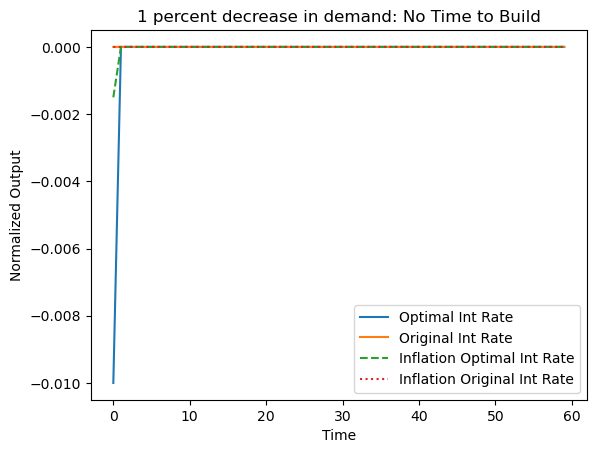

In [46]:

import matplotlib.pyplot as plt
plt.plot( C_consumption[matches,].T, label='Optimal Int Rate')
plt.plot( C_consumption[argmins_gap,].T, label='Original Int Rate')
plt.plot( pi_inflation[matches,].T, label='Inflation Optimal Int Rate', linestyle='dashed')
plt.plot( pi_inflation[argmins_gap,].T, label='Inflation Original Int Rate', linestyle='dotted')
plt.legend()
plt.title('1 percent decrease in demand: No Time to Build')
plt.xlabel('Time')
plt.ylabel('Normalized Output') 
plt.show()

In [47]:
import numpy as np

def solve_wage_sticky_flexprice_with_productivity(
    T,
    beta=0.99, sigma=1.0, phi=3.0, kappa_w=0.05,
    # shocks (length T): u_t is IS wedge; a_t is productivity (log level)
    u_seq=None, a_seq=None,
    # policy closure
    closure="taylor", phi_pi=1.5,      # or closure="custom_i"
    i_seq=None,
    # terminal conditions for inflation
    pi_T=0.0, pi_Tplus1=0.0
):
    """
    Deterministic NK with Rotemberg sticky wages + FLEXIBLE prices + productivity shock a_t.
    Equations:
      (1) π_t = β π_{t+1} + K c_t - B a_t + βΔa_{t+1} - Δa_t
          where K = κ_w(σ+φ), B = κ_w(1+φ), Δa_t = a_t - a_{t-1}
      (2) c_t = c_{t+1} - (1/σ) (i_t - π_{t+1} - r_t^n),
          r_t^n = σ (c^n_{t+1} - c^n_t) + u_t,   c^n_t = ((1+φ)/(σ+φ)) a_t

    Returns dict with π (goods inflation), π_w (wage inflation), c, y, n, i, r_nat, residual checks.
    """
    # --- inputs & padding ---
    if u_seq is None: u_seq = np.zeros(T)
    if a_seq is None: a_seq = np.zeros(T)
    u = np.asarray(u_seq, float); a_core = np.asarray(a_seq, float)
    if len(u) != T or len(a_core) != T:
        raise ValueError("u_seq and a_seq must have length T")

    # pad a for references to a_{t-1}, a_{t+1}, a_{t+2}
    a = np.zeros(T+2+1)        # indices 0..T+2 with a[-1] handled via a[0]
    a[1:1+T] = a_core          # a[1]=a_0, ... a[T]=a_{T-1}; a[0]=a_{-1}=0; a[T+1], a[T+2]=0
    # Δa_t needs a_{t-1}; define helper:
    def delta(a_arr, t):       # Δa_t using padded 'a' where a[t] is a_{t-1} in core time
        return a_arr[t+1] - a_arr[t]

    K = kappa_w * (sigma + phi)
    B = kappa_w * (1.0 + phi)
    delta_coeff = (1.0 + phi) / (sigma + phi)   # ≡ δ; so K*δ = B

    # --- policy rule / interest sequence ---
    if closure == "custom_i":
        if i_seq is None or len(i_seq) != T:
            raise ValueError("Provide i_seq of length T when closure='custom_i'")
        i = np.asarray(i_seq, float)
    elif closure == "taylor":
        i = None  # computed after π is solved: i_t = φ_π π_t
    else:
        raise ValueError("closure must be 'taylor' or 'custom_i'")

    # --- inflation recursion with productivity ---
    # Start from K(c_t - c_{t+1}) expression and IS; yields:
    # π_t = [(1+β) - K/σ] π_{t+1} - β π_{t+2} + (K/σ) i_t - (K/σ) u_t
    #       - β a_{t+2} + (2β+1) a_{t+1} - (β+2) a_t + a_{t-1}
    pi = np.zeros(T+2)       # π_T and π_{T+1} pinned by terminal conditions
    pi[T] = pi_T; pi[T+1] = pi_Tplus1

    A = (1.0 + beta) - (K / sigma)     # coeff on π_{t+1}
    for t in range(T-1, -1, -1):
        # productivity term uses padded 'a' at indices shifted by +1 relative to core time
        prod = (-beta * a[t+3]               # a_{t+2}
                + (2*beta + 1.0) * a[t+2]    # a_{t+1}
                - (beta + 2.0) * a[t+1]      # a_t
                + a[t])                      # a_{t-1}

        if closure == "custom_i":
            it = i[t]
        else:
            # temporarily unknown; use i_t = φ_π * π_t on the SAME date ⇒ move term to LHS
            # Rearranged under Taylor rule gives:
            # (1 + (K/σ)φ_π) π_t = A π_{t+1} - β π_{t+2} + (K/σ) u_t + prod
            denom = 1.0 + (K/ sigma) * phi_pi
            pi[t] = (A * pi[t+1] - beta * pi[t+2] + (K/ sigma) * u[t] + prod) / denom
            continue

        # custom i: direct recursion
        pi[t] = A * pi[t+1] - beta * pi[t+2] + (K/ sigma) * i[t] - (K/ sigma) * u[t] + prod

    if closure == "taylor":
        i = phi_pi * pi[:T]

    # --- recover c_t from the wage-NKPC with productivity ---
    # K c_t = π_t - β π_{t+1} + B a_t - β Δa_{t+1} + Δa_t
    c = np.zeros(T)
    for t in range(T):
        Da_t   = delta(a, t)           # Δa_t
        Da_t1  = delta(a, t+1)         # Δa_{t+1}
        at     = a[t+1]                # a_t
        c[t] = (pi[t] - beta * pi[t+1] + B * at - beta * Da_t1 + Da_t) / K

    # natural rate and allocations
    c_nat = delta_coeff * a[1:1+T]                       # c^n_t = δ a_t
    r_nat = sigma * (c_nat[1:] - c_nat[:-1])             # length T-1; pad
    r_nat = np.r_[r_nat, 0.0] + u                        # add IS wedge u_t

    # identities
    y = c.copy()
    n = c - a[1:1+T]
    pi_w = pi[:T] + (a[2:2+T] - a[1:1+T])                # π^w = π + Δa

    # residual checks
    is_resid = c - np.r_[c[1:], 0.0] + (1.0/sigma)*(i - pi[1:T+1] - r_nat)
    nkpc_resid = (pi[:T] + (a[2:2+T]-a[1:1+T])) - beta*(pi[1:T+1] + (a[3:3+T]-a[2:2+T])) \
                 + kappa_w*((1+phi)*a[1:1+T] - (sigma+phi)*c)

    return {
        "pi": pi[:T], "pi_w": pi_w, "c": c, "y": y, "n": n,
        "i": i, "u": u, "a": a[1:1+T], "r_nat": r_nat,
        "is_resid": is_resid, "nkpc_resid": nkpc_resid
    }

# --------------- Example ---------------
if __name__ == "__main__":
    T = 60
    # AR(1) productivity level a_t with a 1% shock at t=0
    rho_a, a0 = 0.7, 0.01
    a_seq = np.zeros(T); a_seq[0] = a0
    for t in range(1, T): a_seq[t] = rho_a * a_seq[t-1]

    # demand wedge u_t (optional): here zero
    u_seq = np.zeros(T)

    # Taylor-rule closure
    res = solve_wage_sticky_flexprice_with_productivity(
        T, beta=0.99, sigma=1.0, phi=3.0, kappa_w=0.05,
        u_seq=u_seq, a_seq=a_seq,
        closure="taylor", phi_pi=1.5
    )
    print("max|IS residual|:", np.max(np.abs(res["is_resid"])))
    print("max|wage-NKPC residual|:", np.max(np.abs(res["nkpc_resid"])))


max|IS residual|: 0.004961473407261529
max|wage-NKPC residual|: 0.013891


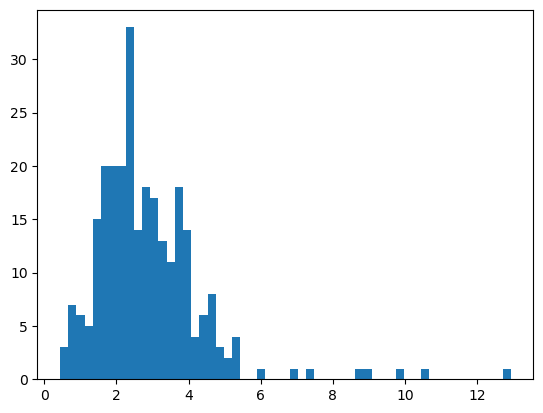

/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_52173/556569987.py:14: RuntimeWarning: divide by zero encountered in log
  N = -(data_tau) - 1/np.log(beta*c)
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_52173/556569987.py:15: RuntimeWarning: divide by zero encountered in log
  tau1= -1/np.log(beta*c) - N
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_52173/556569987.py:17: RuntimeWarning: divide by zero encountered in log
  tau2= -1/np.log(beta1*c) - N


In [48]:
import numpy as np
import math as mp
import pandas as pd
data=pd.read_csv('APP_data_usa_goods.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
data_tau=(data['invtCogsRatio']* 36.5/(30*0.1))
import matplotlib.pyplot as plt
plt.hist(data_tau,bins = 55)
plt.show()
tau_diff = np.zeros(( 1000,1))
i = 0
beta = 1/1.01
beta1 =1/( (1.0 +0.01* np.exp(30/(36.5*0.9)))) 
for c in np.linspace(0, 0.99, 1000): 
    N = -(data_tau) - 1/np.log(beta*c) 
    tau1= -1/np.log(beta*c) - N
    tau1[tau1<0] = 0     
    tau2= -1/np.log(beta1*c) - N
    tau2[tau2<0] = 0    
    tau_diff[i] = np.mean(np.abs(tau1-tau2))
    i = i+1
min_val = np.min(np.abs(tau_diff-1))
argmins = np.where(np.abs(tau_diff-1) == min_val)[0]
c_list = np.linspace(0, 0.99, 1000)
c=c_list[argmins]

In [49]:
N=-data_tau - 1/np.log(beta_hh*c) 
tau= -1/np.log(beta_hh*c) - N
tau[tau<0] = 0  
tau_floor = np.floor(tau)
tau_ceil = np.ceil(tau)
tprod_ceil=  (beta_hh*c)**tau_ceil * (tau_ceil + N)
tprod_floor=  (beta_hh*c)**tau_floor * (tau_floor + N)
tau[(tprod_ceil-tprod_floor)>0] = tau_ceil[(tprod_ceil-tprod_floor)>0]
tau[(tprod_ceil-tprod_floor)<0] = tau_floor[(tprod_ceil-tprod_floor)<0]
tau[tau<0] = 0  

tprod = (beta*c)**tau * (tau + N)
tprod_array = np.array([tprod])

In [50]:
import numpy as np
import itertools

sequence_length = 6
r_choice = np.linspace(0, 0.0125, 6)  # 6 values from 0 to 0.0125 inclusive

# Generate all possible combinations (Cartesian product)
all_combinations = list(itertools.product(r_choice, repeat=sequence_length))

# Convert to NumPy array
big_array = np.array(all_combinations)

print(big_array.shape)  # Should be (6^6, 6) = (46656, 6)

# Assign to r_arrange
r_arrange = big_array
size = r_arrange.shape[0]

(46656, 6)


In [51]:
k=0
T=100
deviation_gap = np.zeros((size, 1))
C_consumption = np.zeros((size, T))
pi_inflation = np.zeros((size, T))
u_custom = np.ones(T)*0.01; u_custom[0] =0

N_array = np.array(N)
sigma = 2
# Compute tprod using product of first tau betas
tau_int = tau.astype(int)    
tvals = tau_int.to_numpy()
for r in r_arrange: 
        
    i_path = np.ones(T)*(1/(beta_hh)-1)   # fixed nominal rate
    abar = np.zeros(T)
    eps = np.zeros(T)

    interest_rate_list = np.ones((T,T)) * 0.01
    # Start with all rows = base

    n = len(r_arrange[k])
    r = np.asarray(r_arrange[k], dtype=float)
    fill = 0.01

    arr2d = np.full((n, n), fill, dtype=float)

    # Fill each row with the backward-looking rates
    for i in range(n):
        arr2d[i, :i+1] = r[i::-1]

    # Put into big matrix
    interest_rate_list[0:n, :n] = arr2d

    # Compute beta
    beta = 1.0 / (1.0 + interest_rate_list)

    cumprod_ext = np.ones((T,T+1))
    cumprod_ext[:,1:] = np.cumprod(beta,axis=1)
    beta_prod = cumprod_ext[:,tvals] 

    tprod_array = np.array((beta_prod * 0.9018018) * (((tvals + N_array))*np.ones((T,269)) ))
    prod_shock = np.ones((T,269))
    inside = (tprod_array)**(sigma-1)
    A_prod = np.sum( inside,axis = 1)**(1/(sigma-1))

    i_path = np.ones(T)*0.01  # fixed nominal rate
    i_path[0:sequence_length] = r_arrange[k]  
    a_seq = np.log(A_prod) - np.log(A_prod)[-1]  # log productivity sequence

    res =  solve_wage_sticky_flexprice_with_productivity_fixed(T=T,i_seq=i_path,u_seq=u_custom, a_seq=a_seq)

    deviation_gap[k] = np.sum((res['y_hat'] )**2)  + np.sum((res['pi'] )**2)
    C_consumption[k, :len(res['y_hat'])] = res['y_hat'].flatten()
    pi_inflation[k, :len(res['pi'])] = res['pi'].flatten()
    k = k+1


In [52]:
argmins_gap = np.where(deviation_gap == np.min(deviation_gap))[0]
argmins_gap

array([30844])

In [53]:
r_arrange[argmins_gap]

array([[0.0075, 0.0125, 0.01  , 0.01  , 0.01  , 0.01  ]])

In [54]:
target = np.array([0.01]*sequence_length)

matches = np.all(np.isclose(r_arrange, target), axis=1)

In [55]:
target = np.array([[0.00, 0.01  , 0.01, 0.01  , 0.01  , 0.01  ]])

matches2 = np.all(np.isclose(r_arrange, target), axis=1)

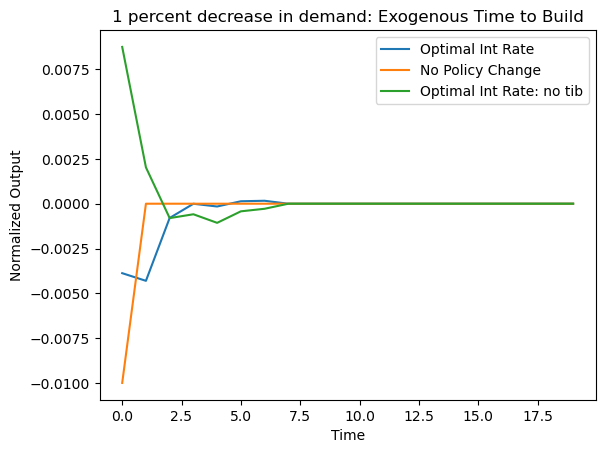

In [58]:
plt.plot( C_consumption[argmins_gap,:20].T, label='Optimal Int Rate')
plt.plot( C_consumption[matches,  :20  ].T, label='No Policy Change' )
plt.plot( C_consumption[matches2,  :20  ].T, label='Optimal Int Rate: no tib' )
plt.legend()
plt.title('1 percent decrease in demand: Exogenous Time to Build')
plt.xlabel('Time')
plt.ylabel('Normalized Output') 
plt.show()

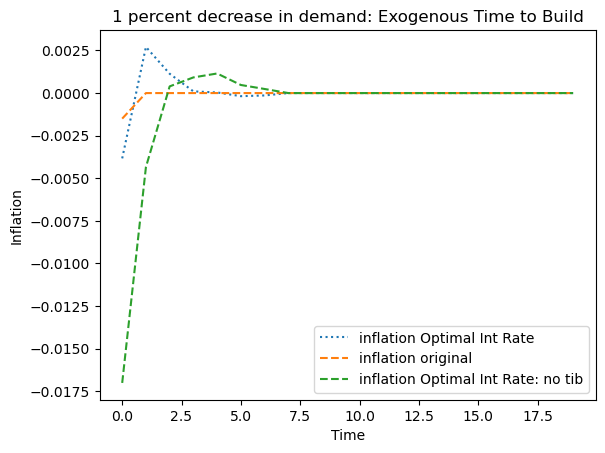

In [60]:
plt.plot( pi_inflation[argmins_gap,:20].T, label='inflation Optimal Int Rate', linestyle='dotted')
plt.plot( pi_inflation[matches,:20].T, label='inflation original', linestyle='dashed')
plt.plot( pi_inflation[matches2,:20].T, label='inflation Optimal Int Rate: no tib', linestyle='dashed')

plt.title('1 percent decrease in demand: Exogenous Time to Build')
plt.xlabel('Time')
plt.ylabel('Inflation') 
plt.legend()
plt.show()

In [29]:
import numpy as np
import itertools

sequence_length = 3
r_choice = np.linspace(0, 0.0125, 6)  # 6 values from 0 to 0.0125 inclusive

# Generate all possible combinations (Cartesian product)
all_combinations = list(itertools.product(r_choice, repeat=sequence_length))

# Convert to NumPy array
big_array = np.array(all_combinations)

print(big_array.shape)  # Should be (6^6, 6) = (46656, 6)

# Assign to r_arrange
r_arrange = big_array
size = r_arrange.shape[0]

(216, 3)


In [30]:
import numpy as np

def find_duplicate_indices_per_row(arr, tol=0.0):
    """
    arr : (R, C) array
    tol : tolerance for considering two values equal (0.0 means exact match)

    Returns:
      list of length R; each item is a list of column indices that are in duplicate groups
    """
    dup_indices = []
    for row in arr:
        if tol > 0:
            # use tolerance
            idxs = []
            for i in range(len(row)):
                for j in range(i+1, len(row)):
                    if abs(row[i] - row[j]) <= tol:
                        idxs.extend([i, j])
            dup_indices.append(sorted(set(idxs)))
        else:
            # exact match
            vals, inv, counts = np.unique(row, return_inverse=True, return_counts=True)
            dups = np.where(counts > 1)[0]            # values that repeat
            cols = np.where(np.isin(inv, dups))[0]    # col indices of those values
            dup_indices.append(cols.tolist())
    return dup_indices

In [31]:
ccccc = 0.9018018

In [32]:
jjjjj = 0
T=100
deviation_gap = np.zeros((size, 1))
C_consumption = np.zeros((size, T))
pi_inflation = np.zeros((size, T))
u_custom = np.ones(T)*0.01; u_custom[0] =0

N_array = np.array(N)
sigma = 2
# Compute tprod using product of first tau betas
tau_int = tau.astype(int)    
tvals = tau_int.to_numpy()

# Compute tprod using product of first tau betas
tau_int = tau.astype(int)    
tvals = tau_int.to_numpy()
for r in r_arrange: 

    interest_rate_list = np.ones((T,T)) * 0.01
    # Start with all rows = base

    n = len(r_arrange[jjjjj])
    r = np.asarray(r_arrange[jjjjj], dtype=float)
    fill = 0.01

    arr2d = np.full((n, n), fill, dtype=float)

    # Fill each row with the backward-looking rates
    for i in range(n):
        arr2d[i, :i+1] = r[i::-1]

    # Put into big matrix
    interest_rate_list[0:n, :n] = arr2d

    # Compute beta
    beta = 1.0 / (1.0 + interest_rate_list)* ccccc

    cumprod_ext = np.ones((T,T+1))
    cumprod_ext[:,1:] = np.cumprod(beta,axis=1)
    tau_list = np.linspace(0, T, T+1)
    time_list_stuff = tau_list*np.ones((T,T+1))
    tprod = (cumprod_ext )[:, :, None] * (time_list_stuff[:, :, None] + np.array(N)[None, None, :])
    tprod_array = np.array(tprod)

    # idx_max will be (30, 269), giving the best column index for each (i, k)
    idx_max = np.argmax(tprod_array, axis=1)  # axis=1 corresponds to the 31 columns

    # Now gather the max values
    max_vals = np.max(tprod, axis=1)    # shape (30, 269)

    tau_best = idx_max


    time_period=np.linspace(0,T-1,T)*np.ones_like(tau_best).T
    tau_timing= tau_best.T + time_period
    Productivity = np.zeros((len(tau_timing), T))
    Productivity = max_vals.T
    shocky = 1


    duplicates = find_duplicate_indices_per_row(tau_timing)
    for i in range(len(tau_timing)):
        k = 0
        for j in tau_timing[i,tau_timing[i,:]<T]:
            if k in duplicates[i]:
                for kkk in duplicates[i]:
                    if tau_timing[i,kkk] == j:
                        if k == 0:
                            big=shocky* max_vals[k,i] > max_vals[kkk,i]
                            if big == True:
                                Productivity[i,int(j)] = shocky* max_vals[k,i]
                                Productivity[i,int(tau_timing[i,kkk])] = 0
                            else:
                                Productivity[i,int(j)] = 0
                        else:
                            big= max_vals[k,i] > max_vals[kkk,i]
                            if big == True:
                                Productivity[i,int(tau_timing[i,kkk])] = 0
                            else:
                                Productivity[i,int(j)] = 0
            else:
                if k ==0:
                    Productivity[i,int(j)] = shocky* max_vals[k,i]
            k = k+1
    A_prod = np.sum( (Productivity)**(sigma-1),axis = 0)**(1/(sigma-1))
    
    i_path = np.ones(T)*0.01  # fixed nominal rate
    i_path[0:sequence_length] = r_arrange[jjjjj]  
    a_seq = (np.log(A_prod) -  np.log(A_prod)[-1]) # log productivity sequence

    res = solve_wage_sticky_flexprice_with_productivity_fixed(
    T,
    # shocks (length T): u_t is IS wedge; a_t is productivity (log level)
    u_seq=u_custom, a_seq=a_seq,
    closure="custom_i",
    i_seq=i_path,
    # terminal conditions for inflation
    pi_T=0.0, pi_Tplus1=0.0
)    
    deviation_gap[jjjjj] = np.sum((res['y_hat'] )**2)  + np.sum((res['pi'] )**2)
    C_consumption[jjjjj, :len(res['y_hat'])] = res['y_hat'].flatten() 
    pi_inflation[jjjjj, :len(res['pi'])] = res['pi'].flatten()
    jjjjj = jjjjj+1

In [33]:
argmins_gap = np.where(deviation_gap == np.min(deviation_gap))[0]
argmins_gap

array([172])

In [34]:
r_arrange[argmins_gap]

array([[0.01, 0.01, 0.01]])

In [35]:
target = np.array([0.01]*sequence_length)

matches = np.all(np.isclose(r_arrange, target), axis=1)

In [36]:
target = np.array([[0.0075, 0.01  , 0.0125  ]])

matches2 = np.all(np.isclose(r_arrange, target), axis=1)

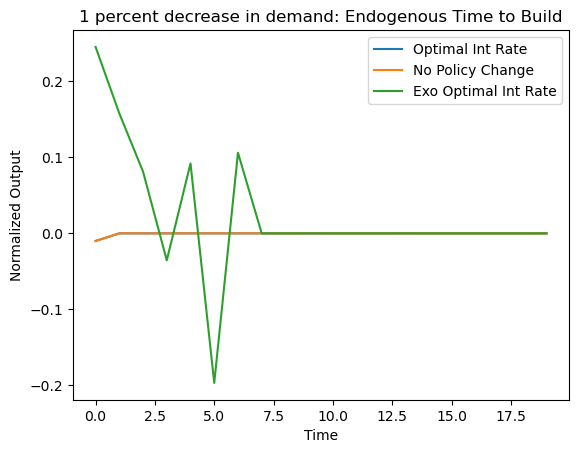

In [37]:
plt.plot( C_consumption[argmins_gap,:20].T, label='Optimal Int Rate')
plt.plot( C_consumption[matches,  :20  ].T, label='No Policy Change' )
plt.plot( C_consumption[matches2,  :20  ].T, label='Exo Optimal Int Rate' )


plt.legend()
plt.title('1 percent decrease in demand: Endogenous Time to Build')
plt.xlabel('Time')
plt.ylabel('Normalized Output') 
plt.show()

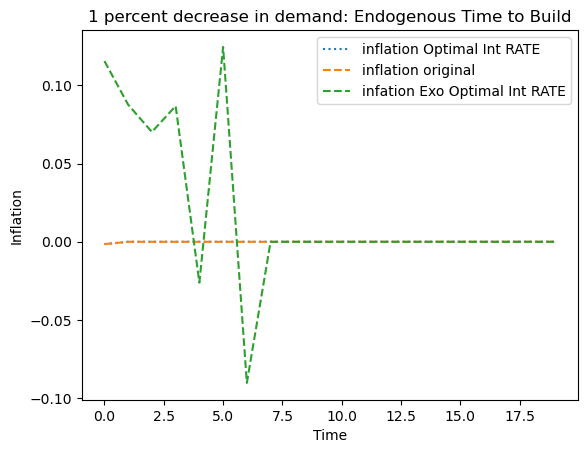

In [38]:

plt.plot( pi_inflation[argmins_gap,:20].T, label='inflation Optimal Int RATE', linestyle='dotted')
plt.plot( pi_inflation[matches,:20].T, label='inflation original', linestyle='dashed')
plt.plot( pi_inflation[matches2,:20].T, label='infation Exo Optimal Int RATE', linestyle='dashed')
plt.title('1 percent decrease in demand: Endogenous Time to Build')
plt.xlabel('Time')
plt.ylabel('Inflation') 
plt.legend()
plt.show()